# Problem Set #10

## Tc2037 Implementation of Computational Methods

April 8, 2021.

_Authors of this notebook’s solution:_

- _Student ID and Name:_
- _Student ID and Name:_

**Instructions:** Follow the indications contained in this notebook. Complete the code where required.

In [1]:
;; External function required for this notebook.
(require '[clojure.test :refer [is]])

nil

## Automaton

The term “automaton” is derived from the Greek word “αὐτόματον” which means “self-acting”. An automaton (_automata_ in plural) is an abstract self-propelled computing device which follows a predetermined sequence of operations automatically.

## Finite Automaton

An automaton with a finite number of states is called a _Finite Automaton_ (FA) or _Finite State Machine_ (FSM).

Formally, a finite automaton can be represented by a 5-tuple $(Q, \Sigma, \delta, q_0, F)$, where: 

* $Q$ is a finite set of states.  
* $\Sigma$ is a finite set of symbols, called the _alphabet_ of the automaton.
* $\delta$ is the transition function.  
* $q_0$ is the initial state from where any input is processed ($q_0 \in Q$).
* $F$ is a set of final states ($F \subseteq  Q$). 

Finite automaton can be classified into two types:

* _Deterministic Finite Automaton_ (DFA) 
* _Non-deterministic Finite Automaton_ (NFA) 

## Additional Terminology

* **Alphabet**: An alphabet is any finite set of symbols. 
For example, $\Sigma = \{ a, b \}$, where $a$ and $b$ are symbols.

* **String**: A string is a finite sequence of symbols taken from $\Sigma$. For example, $abba$ is a valid string on the alphabet $\Sigma = \{a, b \}$.

* **Length of a String**: It is the number of symbols present in a string $S$ and it is denoted by $|S|$. Examples:
  * If $S = abba$, $|S|= 4$   
  
  * If $|S|= 0$, it is called an _empty string_ and is denoted by $\varepsilon$.  
  
* **Kleen Star**: The Kleene star $\Sigma^*$, is a unary operator on a set of symbols or strings $\Sigma$, that gives the infinite set of all possible strings of all possible lengths over $\Sigma$, including $\varepsilon$. For example, if $\Sigma = \{ a, b \}$, then $\Sigma^* = \{ \varepsilon, a, b, aa, ab, ba, bb, aaa, \ldots \}$.

* **Kleen Plus**: The set $\Sigma^+$ is the infinite set of all possible strings of all possible lengths over $\Sigma$, excluding $\varepsilon$. For example, if $\Sigma = \{ a, b \}$, then $\Sigma^+ = \{ a, b, aa, ab, ba, bb, aaa, \ldots \}$.

* **Language**: A language $L$ is a subset of $\Sigma^*$ for some alphabet $\Sigma$. It can be finite or infinite.  For example, if the language takes all possible strings of length 2 over $\Sigma = \{ a, b \}$, then $L = \{ aa, ab, ba, bb \}$. 

## Deterministic Finite Automaton (DFA)

In a DFA, for each input symbol, one can determine the state to which the machine will move. Hence, it is called _Deterministic Automaton_. As it has a finite number of states, the machine is called _Deterministic Finite Automaton_.

A DFA is represented by a directed graph called _state diagram_.  

* The vertices represent the states.
* The arcs labeled with an input alphabet show the transitions.  
* The initial state is denoted by an empty single incoming arc. 
* The final state is indicated by double circles.

## DFA Example

We have the following DFA:

* $Q = \{ q_0, q_1, q_2 \}$   
* $\Sigma = \{ a, b\}$
* $q_0 =$ Initial state
* $F = \{ q_2 \}$
* This table shows the transition function $\delta$:

| Current State | Next state for input $a$ | Next state for input $b$ |
|:-------------:|:------------------------:|:------------------------:|
|     $q_0$     |           $q_1$          |           $q_0$          |
|     $q_1$     |           $q_1$          |           $q_2$          |
|     $q_2$     |           $q_2$          |           $q_2$          |

And this is the corresponding state diagram:

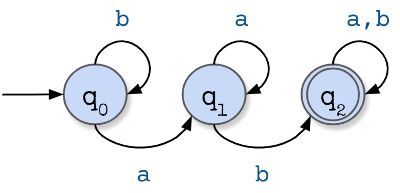

## Exercise A

1. _Indicate if the machine **accepts** or **rejects** the following strings:_

|    | String | Accepts | Rejects |
|----|--------|:-------:|:-------:|
| a) |   $a$  |         |    x    |
| b) |  $ab$  |    x    |         |
| c) |  $baa$ |         |    x    |
| d) | $abba$ |    x    |         |
| e) | $aaab$ |    x    |         |
| f) | $bbba$ |         |    x    |

2. _Describe in your own words the strings accepted by this machine._ This DFA accepts any string that contains the subsequence $ab$.

## DFA Simulation

We define a record to represent the information related to the transition function $\delta$.

In [2]:
(defrecord Rule [state character next-state])

user.Rule

The transition function for a DFA can be represented as a vector of `Rule` objects, which will be referred from now as a _rulebook_. For the previous DFA example it would look like this:

In [3]:
(def rb-example1 [(->Rule 0 \a 1)
                  (->Rule 0 \b 0)
                  (->Rule 1 \a 1)
                  (->Rule 1 \b 2)
                  (->Rule 2 \a 2)
                  (->Rule 2 \b 2)])

#'user/rb-example1

We now need some code to establish a simple API for rules.

For a given rule, the `applies-to?` function returns `true` or `false` to indicate whether that rule applies in a particular situation given a state and a character.

In [4]:
(defn applies-to?
  [rule state character]
  (and (= (:state rule) state)
       (= (:character rule) character)))

#'user/applies-to?

In [5]:
(let [r1 (->Rule 0 \a 1)
      r2 (->Rule 1 \b 2)]
  (is (applies-to? r1 0 \a))
  (is (applies-to? r2 1 \b))
  (is (not (applies-to? r1 0 \b)))
  (is (not (applies-to? r2 2 \a))))

true

The `follow` function returns the state that the machine should change to when a rule is followed.

In [6]:
(defn follow
  [rule]
  (:next-state rule))

#'user/follow

In [7]:
(let [r1 (->Rule 0 \a 1)
      r2 (->Rule 1 \b 2)]
  (is (= 1 (follow r1)))
  (is (= 2 (follow r2))))

true

We now define a record to represent a deterministic finite automaton.

In [8]:
(defrecord DFA [current-state accept-states rulebook])

user.DFA

The `rule-for` function finds the specific `Rule` object contained in a rulebook that can be applied to a given state and character. We will assume that there is exactly one rule that meets this criteria.

In [9]:
(defn rule-for
  [rulebook state character]
  ;;; your code goes here
  (some #(if (applies-to? % state character) % nil)
        rulebook))

#'user/rule-for

In [10]:
(let [r1 (->Rule 0 \a 1)
      r2 (->Rule 1 \b 2)
      r3 (->Rule 2 \a 2)]
  (is (= r1 (rule-for rb-example1 0 \a)))
  (is (= r2 (rule-for rb-example1 1 \b)))
  (is (= r3 (rule-for rb-example1 2 \a))))

true

The `next_state` function uses the `rule-for` and `follow` functions to locate the correct rule and discover what the next state of the DFA should be.

In [11]:
(defn next-state 
  [rulebook state character]
  (follow (rule-for rulebook state character)))

#'user/next-state

In [12]:
(is (= 1 (next-state rb-example1 0 \a)))
(is (= 0 (next-state rb-example1 0 \b)))
(is (= 2 (next-state rb-example1 1 \b)))

true

The `accepting?` function checks if the current state of a DFA object is an accepting state.

In [13]:
(defn accepting?
  [dfa]
  (contains? (:accept-states dfa) (:current-state dfa)))

#'user/accepting?

In [14]:
(let [dfa1 (->DFA 0 #{0 2} rb-example1)
      dfa2 (->DFA 0 #{2} rb-example1)]
  (is (accepting? dfa1))
  (is (not (accepting? dfa2))))

true

The `process-character` function takes an input character, consults the rulebook from the given DFA, and returns a new DFA with its current state updated accordingly.

In [15]:
(defn process-character
  [dfa character]
  (assoc dfa
         :current-state
         (next-state (:rulebook dfa)
                     (:current-state dfa)
                     character)))

#'user/process-character

In [16]:
(is (= 1 (:current-state (process-character (->DFA 0 #{} rb-example1) \a))))
(is (= 2 (:current-state (process-character (->DFA 2 #{} rb-example1) \b))))

true

The `accepts?` function takes a DFA and an input string. It returns `true` if the DFA accepts the given string or `false` otherwise. 

In [17]:
(defn accepts?
  [dfa input]
  (if (empty? input)
    (accepting? dfa)
    (recur (process-character dfa (first input))
           (rest input))))

#'user/accepts?

In [18]:
(let [dfa (->DFA 0 #{2} rb-example1)]
  (is (not (accepts? dfa "a")))
  (is (accepts? dfa "ab"))
  (is (not (accepts? dfa "baa")))
  (is (accepts? dfa "abba"))
  (is (accepts? dfa "aaab"))
  (is (not (accepts? dfa "bbba")))
  (is (accepts? dfa "baaaaab"))
  (is (not (accepts? dfa "bbbbbaaaaa"))))

true

## Exercise B

_For the following problems: A) build the requested DFAs including the corresponding state diagram, and B) simulate them in code._

1. From an alphabet $\Sigma = \{ 0, 1 \}$, design a DFA that accepts strings that start with 0 and end with 1, and rejects all other strings. Write unit tests that verify that $01$, $0101$, $01111$, and $000001$ are accepted, while $\varepsilon$, $00$, $1001011$, $1001010$ are rejected.

2. Design a DFA with alphabet $\Sigma = \{ x, y \}$ that accepts any string that contains a sequence of three consecutive $y$ symbols, and rejects anything else. Write unit tests that verify that $yyy$, $xyxyyyx$, $xxxxxyyyyy$, and $yyyxxxxyyy$ are accepted, while $\varepsilon$, $yyx$, $yxxyxxy$, $xyxyyxyyx$ are rejected.

### Solution to Exercise B.1

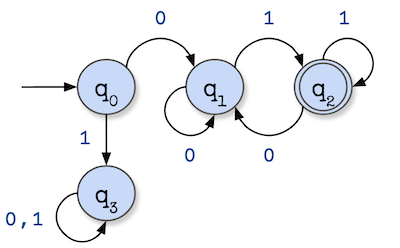

* $Q = \{ q_0, q_1, q_2, q_3 \}$   
* $\Sigma = \{ 0, 1 \}$
* $q_0 =$ Initial state
* $F = \{ q_2 \}$
* This table shows the transition function $\delta$:

| Current State | Next state for input $0$ | Next state for input $1$ |
|:-------------:|:------------------------:|:------------------------:|
|     $q_0$     |           $q_1$          |           $q_3$          |
|     $q_1$     |           $q_1$          |           $q_2$          |
|     $q_2$     |           $q_1$          |           $q_2$          |
|     $q_3$     |           $q_3$          |           $q_3$          |

In [ ]:
(let [rulebook [(->Rule 0 \0 1)
                (->Rule 0 \1 3)
                ;...
                ]
      dfa (->DFA 0 #{2} rulebook)]
  (is (accepts? dfa "01"))
  ; ...
  )

### Solution to Exercise B.2